# Subject Models

In [ ]:
import pandas as pd
import json 

with open('index.txt', 'r') as index_file:
    rows = []
    for line in index_file:
        line = line.strip()
        model_name, metadata_string = line.split(' ', maxsplit=1)
        metadata = json.loads(metadata_string)
        metadata['name'] = model_name
        rows.append(metadata)

weight_decay = pd.DataFrame(rows)

## Sparsity

In [47]:
import pandas as pd

with open("sparsity.txt", 'r') as sparsity_file:
    rows = []
    for line in sparsity_file:
        line = line.strip()
        name, sparsity = line.split(', ')
        rows.append((name, float(sparsity)))

sparsity = pd.DataFrame(rows, columns=['name', 'sparsity'])
weight_decay_sparsity = pd.merge(weight_decay[['name', 'weight_decay']], sparsity, on='name', how='inner')
weight_decay_sparsity.head()

,name,weight_decay,sparsity
0,aab35ece-643f-443c-a9e1-0a0c71768beb,0.1000,40.444444
1,de5dbb97-aa02-4cf0-96f5-e19f7befe7a3,0.0001,84.296296
2,16fd4d22-3030-4ede-a240-6f25693a2c8e,1.0000,40.888889
3,e22a8a91-d93f-42b6-a623-2c3056771081,1.0000,51.407407
4,9d26485b-1d09-49e1-9903-df0aa17162db,0.0000,58.962963


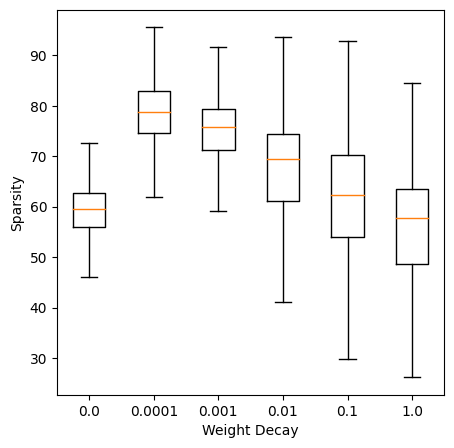

In [50]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(5, 5))

grouped = weight_decay_sparsity.groupby('weight_decay')
data = [group['sparsity'].tolist() for _, group in grouped]
labels = grouped.groups.keys()
ax.boxplot(data, labels=labels, showfliers=False)
ax.set_xlabel('Weight Decay')
ax.set_ylabel('Sparsity')

plt.show()

## Performance

In [2]:
# TODO: Get the losses for the other pruning amounts
with open('pruned_losses.txt', 'r') as pruned_losses:
    rows = []
    for line in pruned_losses:
        name, loss = line.strip().split(' ')
        rows.append((name, float(loss)))
pruned_losses = pd.DataFrame(rows, columns=['name', 'loss'])
pruned_losses['prune_amount'] = 0.2

zero_decay_rows = weight_decay[weight_decay['weight_decay'] == 0]
zero_decay_rows = zero_decay_rows.drop('loss', axis=1)
pruned_models = pd.merge(zero_decay_rows, pruned_losses, on='name', how='inner')

weight_decay['prune_amount'] = 0.
subject_models = pd.concat([weight_decay, pruned_models])

subject_models.head()

,fn_name,parameter,loss,seed,weight_decay,epochs,name,prune_amount
0,multiplication,0.356396,1.151715e-04,726,0.1000,10000,aab35ece-643f-443c-a9e1-0a0c71768beb,0.0
1,min,0.659066,1.163055e-06,3856,0.0001,10000,de5dbb97-aa02-4cf0-96f5-e19f7befe7a3,0.0
2,exponent,0.632487,6.036503e-02,1076,1.0000,10000,16fd4d22-3030-4ede-a240-6f25693a2c8e,0.0
3,exponent,0.293628,6.916875e-02,686,1.0000,10000,e22a8a91-d93f-42b6-a623-2c3056771081,0.0
4,multiplication,0.072917,2.953429e-09,2061,0.0000,10000,9d26485b-1d09-49e1-9903-df0aa17162db,0.0


In [3]:
subject_models['fn_name'].value_counts()

fn_name
exponent          73121
sigmoid           70035
addition          70033
multiplication    70001
min               69330
Name: count, dtype: int64

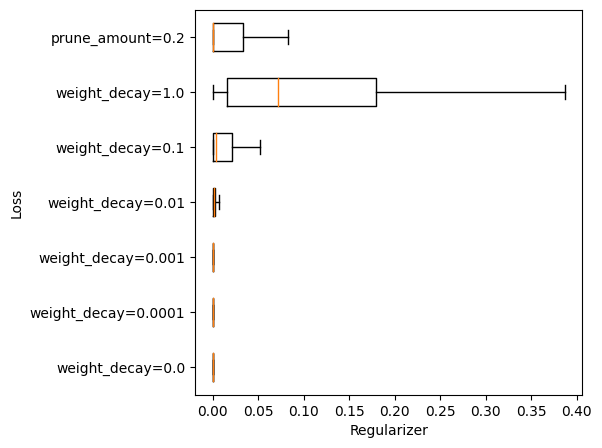

In [21]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(5, 5))

weight_decay_groups = subject_models[subject_models['prune_amount'] == 0.].groupby('weight_decay')
weight_decay_data = [group['loss'].tolist() for _, group in weight_decay_groups]
weight_decay_labels = [f'weight_decay={wd}' for wd in weight_decay_groups.groups.keys()]

prune_amount_groups = subject_models[(subject_models['weight_decay'] == 0.) & (subject_models['prune_amount'] > 0.)].groupby('prune_amount')
prune_amount_data = [group['loss'].tolist() for _, group in prune_amount_groups]
prune_amount_labels = [f'prune_amount={pa}' for pa in prune_amount_groups.groups.keys()]

data = weight_decay_data + prune_amount_data
labels = weight_decay_labels + prune_amount_labels


ax.boxplot(data, labels=labels, showfliers=False, vert=False)
ax.set_xlabel('Regularizer')
ax.set_ylabel('Loss')

plt.show()

# Interpretability models

In [51]:
import wandb
from train_subject_models import FUNCTION_NAMES
from datetime import datetime

api = wandb.Api()
runs = api.runs(
    path='patrickaaleask/bounding-mi',
    filters= {
        'config.functions': FUNCTION_NAMES,
        'State': 'finished',
        'created_at': {
            '$gt': "2023-06-26T00:00:00",
            # '$lt': "2023-06-27T00:00:00",
        },
    },
)
print(f'Found {len(list(runs))} runs')

Found 71 runs


In [56]:
import pandas as pd
from scipy import stats

run_data = []
for run in runs:
    if run.summary['_wandb']['runtime'] < 10:
        continue
    try:
        prune_amount = run.config['prune_amount']
    except KeyError:
        prune_amount = 0.
    run_data.append((run.config['weight_decay'], prune_amount, run.summary['validation_loss']))

interp_models = pd.DataFrame(run_data, columns=['weight_decay', 'prune_amount', 'loss'])
interp_models.head()


,Weight Decay,Prune Amount,Loss
0,0.0,0.2,0.025061
1,0.0,0.2,0.024917
2,0.0,0.2,0.025308
3,1.0,0.0,0.014947
4,1.0,0.0,0.014900


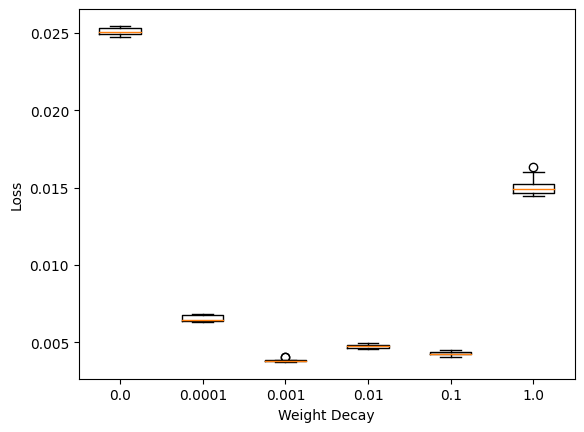

In [54]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(5, 5))

weight_decay_groups = subject_models[subject_models['prune_amount'] == 0.].groupby('weight_decay')
weight_decay_data = [group['loss'].tolist() for _, group in weight_decay_groups]
weight_decay_labels = [f'weight_decay={wd}' for wd in weight_decay_groups.groups.keys()]

prune_amount_groups = subject_models[(subject_models['weight_decay'] == 0.) & (subject_models['prune_amount'] > 0.)].groupby('prune_amount')
prune_amount_data = [group['loss'].tolist() for _, group in prune_amount_groups]
prune_amount_labels = [f'prune_amount={pa}' for pa in prune_amount_groups.groups.keys()]

data = weight_decay_data + prune_amount_data
labels = weight_decay_labels + prune_amount_labels


ax.boxplot(data, labels=labels, showfliers=False, vert=False)
ax.set_xlabel('Regularizer')
ax.set_ylabel('Loss')

plt.show()

# Create a figure and axis object
fig, ax = plt.subplots()

# Group the dataframe by 'Class'
grouped = df.groupby('Weight Decay')

# Create a list of data for each class
data = [group['Loss'].tolist() for name, group in grouped]

# Plot the boxplot
ax.boxplot(data, labels=grouped.groups.keys())

# Set x-axis and y-axis labels
ax.set_xlabel('Weight Decay')
ax.set_ylabel('Loss')

# Show the plot
plt.show()

In [16]:
weight_decays = sorted(df['Weight Decay'].unique())

f_value, p_value = stats.f_oneway(*[df['Validation Loss'][df['Weight Decay'] == weight_decay] for weight_decay in weight_decays])

print(f'F-value: {f_value:.2f}')
print(f'p-value: {p_value}')

F-value: 7819.33
p-value: 6.647503941303006e-76


In [35]:
import torch


SUBJECT_MODEL_PARAMETER_COUNT = 726
class FeedForwardNN(nn.Module):
    def __init__(self, out_size):
        super().__init__()
        self.fc1 = nn.Linear(SUBJECT_MODEL_PARAMETER_COUNT, 128)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(64, out_size)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        function_encoding = self.softmax(x[:, :-1])
        x = torch.cat([function_encoding, x[:, -1:]], dim=-1)
        return x

nn = FeedForwardNN(5)

sum(p.numel() for p in nn.parameters())

101637